In [1]:
%%capture
%pip install transformers datasets

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizer

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset introduction and pre-processing
The classification task will be done on the IMDB review Dataset. Reviews are either labeled "positive" or "negative". The reviews are also quite long on average, so it will be a good opportunity to observe the performance gained on computation time using Linformer. 

In [4]:
from datasets import load_dataset
import unicodedata
import re
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", do_lower_case=True
)
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)
print(dataset[0])

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})
{'review': "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are 

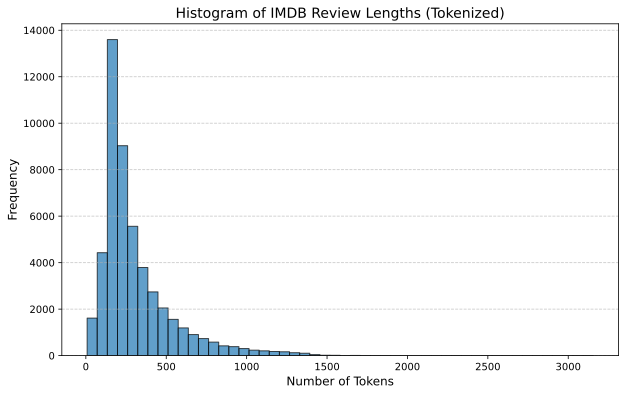

In [5]:
review_lengths = [len(tokenizer.tokenize(review['review'])) for review in dataset]

plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=50, edgecolor="k", alpha=0.7)
plt.title("Histogram of IMDB Review Lengths (Tokenized)", fontsize=14)
plt.xlabel("Number of Tokens", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [6]:
def preprocessing_fn(x, tokenizer, max_length):
    encoded = tokenizer.encode_plus(
        x["review"],
        add_special_tokens=True,
        truncation=True,
        max_length=max_length,  
        padding="max_length",  
        return_attention_mask=True,  
    )
    # Assign tokenized data and label
    return {
        "input_ids": encoded["input_ids"],
        "attention_mask": encoded["attention_mask"],
        "label": 1 if x["sentiment"] == "positive" else 0,
    }


In [7]:
n_samples = 50000  # The number of training examples
max_length = 1024 # The maximum length of the input sequence

# Shuffle the data
dataset = dataset.shuffle()

# Select n_samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

# Print a sample to verify
print(splitted_dataset[0])

# Remove useless columns 
splitted_dataset = splitted_dataset.select_columns(["input_ids", "attention_mask", "label"])

# Split the train and validation sets
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'review': "This is a truly wonderful love story. I liked the songs, however even if you do not, you have to love the story. Peter O'Toole is at his best and Petula Clark is doing fine as well. I first saw this when I was about 13 and loved it then. Now in my forties, I still enjoy it, probably even more. Still makes me cry and laugh and feel good. It is a movie to watch only with a new age guy or by yourself as it is a chick flick. But whats wrong with that. Need a little romance and maybe a little cry, try this movie.<br /><br />", 'sentiment': 'positive', 'input_ids': [101, 2023, 2003, 1037, 5621, 6919, 2293, 2466, 1012, 1045, 4669, 1996, 2774, 1010, 2174, 2130, 2065, 2017, 2079, 2025, 1010, 2017, 2031, 2000, 2293, 1996, 2466, 1012, 2848, 1051, 1005, 6994, 2063, 2003, 2012, 2010, 2190, 1998, 9004, 7068, 5215, 2003, 2725, 2986, 2004, 2092, 1012, 1045, 2034, 2387, 2023, 2043, 1045, 2001, 2055, 2410, 1998, 3866, 2009, 2059, 1012, 2085, 1999, 2026, 3481, 3111, 1010, 1045, 2145, 5959, 20

### DataLoader

In [8]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=max_length, return_tensors="pt"
        )
        return features

data_collator = DataCollator(tokenizer)

batch_size = 24 # GPU can handle this much

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

batch = next(iter(train_dataloader))
print("Input IDs:", batch["input_ids"][1])  
print("Mask:", batch["attention_mask"][1])  
print("Labels:", batch["label"][1])  
print("Input IDs length:", batch["input_ids"][1].size())  
print("Mask length:", batch["attention_mask"][1].size())  
print("Labels length:", batch["label"][1].size())  

Input IDs: tensor([ 101, 3150, 2001,  ...,    0,    0,    0])
Mask: tensor([1, 1, 1,  ..., 0, 0, 0])
Labels: tensor(0)
Input IDs length: torch.Size([1024])
Mask length: torch.Size([1024])
Labels length: torch.Size([])


## Model Implementation
In this section, we implement a transformer architecture that can use both the traditionnal multi-head Attention and Linformer multi-head Attention

#### Weights initialization

In [9]:
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, mean=0, std=0.02)
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)

#### Feed-Forward

In [10]:
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(FeedForward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),  
            nn.Dropout(dropout),  
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

#### Classic Multi-Head Self-Attention 

In [11]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d, n_heads, dropout=0.3):
        super(Multi_Head_Attention,self).__init__()
        assert d % n_heads == 0, "Embedding dimension must be divisible by the number of heads"
        
        self.n_heads = n_heads
        self.d_heads = d // n_heads  # Dimension per head

        self.q_proj = nn.Linear(d, d)
        self.k_proj = nn.Linear(d, d)
        self.v_proj = nn.Linear(d, d)
        self.out_proj = nn.Linear(d, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attention_mask=None):
        batch_size, seq_len, d = x.shape
        d_heads = self.d_heads

        # Linear projections
        q = self.q_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (B, H, L, D_head)
        k = self.k_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (B, H, L, D_head)
        v = self.v_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (B, H, L, D_head)

        # Attention scores
        score = q @ k.transpose(-1, -2) * (d_heads**-0.5)

        # Apply Mask
        if attention_mask is not None:
            expanded_mask = attention_mask.unsqueeze(1).unsqueeze(2)
            score = score.masked_fill(expanded_mask == 0, float('-inf'))


        score = torch.softmax(score, dim=-1)
        score = self.dropout(score)  # Apply dropout to attention scores

        # Attention output
        attention = score @ v  # (B, H, L, D_head)
        attention = attention.transpose(1, 2).reshape(batch_size, seq_len, d)  # Merge heads
        attention = self.dropout(attention)
        # Output projection
        out = self.out_proj(attention)  # Project back to original embedding dimension
        return out

#### Linformer Multi-Head Self-Attention

In [12]:
class Multi_Head_Attention_Linformer(nn.Module):
    def __init__(self, input_size, d_heads, d, dim_k, n_heads, dropout):
        super(Multi_Head_Attention_Linformer, self).__init__()
        assert d % n_heads == 0, "Embedding dimension must be divisible by the number of heads"

        self.n_heads = n_heads
        self.d_heads = d_heads
        self.dim_k = dim_k
        self.d = d
        self.out_proj = nn.Linear(d, d)

        self.q_proj = nn.Linear(d, d_heads * n_heads, bias=False)
        self.k_proj = nn.Linear(d, d_heads * n_heads, bias=False)
        self.v_proj = nn.Linear(d, d_heads * n_heads, bias=False)
        self.dropout = nn.Dropout(dropout)

        # Linear projection matrices for K and V
        self.E = nn.Parameter(torch.empty(input_size, dim_k)*d**-0.5)
        self.F = nn.Parameter(torch.empty(input_size, dim_k)*d**-0.5)

    def forward(self, x, attention_mask=None):
        batch_size, seq_len, _ = x.shape

        # Linear projections
        Q = self.q_proj(x).view(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        K = self.k_proj(x).view(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        V = self.v_proj(x).view(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)

        if attention_mask is not None:
            mask = attention_mask[:, None, :, None]  # Shape: (B, 1, seq_len, 1)
            K = K * mask  # Mask K
            V = V * mask  # Mask V


        # Project K and V using E and F
        E, F = self.E[:seq_len, :].to(K.device), self.F[:seq_len, :].to(V.device)
        K = (K.transpose(-2, -1) @ E).transpose(-2, -1)  # (batch_size, n_heads, seq_len, dim_k)
        V = (V.transpose(-2, -1) @ F).transpose(-2, -1)  # (batch_size, n_heads, seq_len, dim_k)

        # Attention scores
        score = (Q @ K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_heads, dtype=Q.dtype).to(Q.device))
        score = torch.softmax(score, dim=-1)
        score = self.dropout(score)

        # Attention output
        attention = score @ V  # (batch_size, n_heads, seq_len, d_heads)
        out = attention.transpose(1, 2).reshape(batch_size, seq_len, -1)  # (batch_size, seq_len, d_heads * n_heads)
        out = self.dropout(out)
        out = self.out_proj(out)
        return out


### Transformer Layer 

In [13]:
class TransformerLayer(nn.Module):
    def __init__(self, d, d_ff, seq_len, k_dim, dropout=0.3, n_heads=8, Linformer_Mode=False):
        super().__init__()
        if Linformer_Mode:
            self.attention = Multi_Head_Attention_Linformer(
                input_size=seq_len, 
                d_heads=d // n_heads, 
                d=d,  
                dim_k=k_dim,  
                n_heads=n_heads,  
                dropout=dropout
            )
        else:
            self.attention = Multi_Head_Attention(d,n_heads, dropout)

        self.feedforward = FeedForward(d, d_ff, d, dropout=dropout)
        self.pre_attention_norm = nn.LayerNorm(d)
        self.post_attention_norm = nn.LayerNorm(d)

    def forward(self, x, attention_mask=None):
        # Attention with residual connection
        normed_x = self.pre_attention_norm(x)
        if isinstance(self.attention, Multi_Head_Attention_Linformer):
            attention = self.attention(normed_x, attention_mask)  # Linformer attention
        else:
            attention = self.attention(normed_x, attention_mask)  # Classic Transformer attention
        y = normed_x + attention

        # Feedforward with residual connection
        normed_y = self.post_attention_norm(y)
        ff_y = self.feedforward(normed_y)
        return normed_y + ff_y

### Classification Head

In [14]:
class Transformer_Classif(nn.Module):
    def __init__(self, d, d_ff, n_classes, vocab_size, max_len=512, k_dim=128, drop=0.3, num_layers=4, n_heads=8, Linformer_Mode=False):
        super().__init__()
        self.wordembeddings = nn.Embedding(vocab_size, d)
        self.position_embeddings = nn.Embedding(num_embeddings=max_len, embedding_dim=d)  
        self.dropout = nn.Dropout(drop)
        self.max_len = max_len

        # Stack of Transformer or Linformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d, d_ff, max_len, k_dim, drop, n_heads, Linformer_Mode=Linformer_Mode) for _ in range(num_layers)
        ])
        self.classif = nn.Linear(d, n_classes)

        # Weight initialization
        self.apply(initialize_weights)

    def forward(self, x, attention_mask=None):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Truncate input if it exceeds max_len
        if seq_len > self.max_len:
            x = x[:, :self.max_len]  
            attention_mask = attention_mask[:, :self.max_len] if attention_mask is not None else None
            seq_len = self.max_len

        # Word and positional embeddings
        X = self.wordembeddings(x)  # (B, L, d)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        position_vectors = self.position_embeddings(positions)  # (B, L, d)
        X = self.dropout(X + position_vectors)

        # Loop over Transformer or Linformer layers
        for layer in self.transformer_layers:
            X = layer(X, attention_mask)

        cls_representation = X[:, 0, :]  # (B, d)

        # Classification layer
        logits = self.classif(cls_representation)  # (B, n_classes)
        return logits

#### Testing

In [15]:
seq_len = 512
batch_size = 8
vocab_size = 30522

x = torch.randint(0, vocab_size, (batch_size, seq_len))

model = Transformer_Classif(
    d=128,
    d_ff=4*128,
    n_classes=2,
    vocab_size=30522,
    max_len=512,
    k_dim=0,
    drop=0.2,
    num_layers=1,
    n_heads=8,
    Linformer_Mode = False
)

logits = model(x)
print("Logits shape:", logits.shape)  # Expected: (batch_size, n_classes)
print("Logits:", logits)

Logits shape: torch.Size([8, 2])
Logits: tensor([[ 0.5113, -1.4602],
        [ 1.2084, -2.8716],
        [ 0.6052,  0.4944],
        [-1.5490,  1.3655],
        [-0.6954, -0.7215],
        [-0.6696,  0.7299],
        [-0.5436,  0.8371],
        [ 2.5125,  0.5823]], grad_fn=<AddmmBackward0>)


In [16]:
seq_len = 512
batch_size = 8
vocab_size = 30522

x = torch.randint(0, vocab_size, (batch_size, seq_len))

model = Transformer_Classif(
    d=128,
    d_ff=4*128,
    n_classes=2,
    vocab_size=30522,
    max_len=512,
    k_dim=128,
    drop=0.2,
    num_layers=1,
    n_heads=8,
    Linformer_Mode = True
)

logits = model(x)
print("Logits shape:", logits.shape)  # Expected: (batch_size, n_classes)
print("Logits:", logits)

Logits shape: torch.Size([8, 2])
Logits: tensor([[-0.6088, -3.5283],
        [ 1.3935, -0.8477],
        [-1.0647, -0.2305],
        [-1.0462, -2.2737],
        [-0.0236, -1.0742],
        [-1.5111, -0.6016],
        [-0.6158, -2.2271],
        [-0.5032, -2.0948]], grad_fn=<AddmmBackward0>)


## Training Functions

In [17]:
def compute_accuracy(predictions, labels):
    pred = predictions.argmax(dim=1)  # (batch_size,)
    # Compare with true class indices
    correct = (labels == pred).sum().item()
    return correct

def train_one_epoch(dataloader, model, optimizer, loss_function):
    model.train()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    for batch in tqdm(dataloader, leave=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        
        # Forward pass with attention_mask
        probs = model(batch["input_ids"], attention_mask=batch["attention_mask"])  # Include mask
        gold = batch["label"]  # (batch_size,)

        correct += compute_accuracy(probs, gold)
        loss = loss_function(probs, gold) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_train  
    return avg_loss, avg_accuracy



def validation_step(dataloader, model, loss_function):
    model.eval()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch in tqdm(dataloader, leave=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass with attention_mask
            probs = model(batch["input_ids"], attention_mask=batch["attention_mask"])  # Include mask
            gold = batch["label"]

            correct += compute_accuracy(probs, gold)
            loss = loss_function(probs, gold)
            total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_valid  
    return avg_loss, avg_accuracy


def train(model, train_dataloader, valid_dataloader, lr=0.0005, n_epochs=3, wd = 1e-4, plot=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(
            f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
    if plot : 
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="train loss")
        plt.plot(valid_losses, label="valid loss")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label="train accuracy")
        plt.plot(valid_accuracies, label="valid accuracy")
        plt.legend()
    return valid_accuracies

## Configuration of the models 

In [21]:
config_classic = {
    "d": 512,
    "d_ff": 4 * 512,
    "vocab_size": 30522,
    "max_len": max_length,  # Can be changed to any value below 1024
    "k_dim": 0,
    "drop": 0.1,
    "num_layers": 3,
    "n_heads": 8,
    "Linformer_Mode": False
}

config_linformer = {
    "d": 512,
    "d_ff": 4 * 512,
    "vocab_size": 30522,
    "max_len": max_length,
    "k_dim": 256,
    "drop": 0.1,
    "num_layers": 3,
    "n_heads": 8,
    "Linformer_Mode": True
}
torch.cuda.empty_cache()

## Training

### Classic Transformer

In [22]:
# Initialize model
model_classic = Transformer_Classif(n_classes=2,**config_classic)
model_classic.to(device)

# Number of Parameters 
total_params = sum(p.numel() for p in model_classic.parameters() if p.requires_grad)
print(f"Number of learnable parameters: {total_params / 1e6:.2f}M")

# Training + computation time recording
start_time = time.time()
if __name__ == '__main__':
    train(model_classic, train_dataloader, valid_dataloader,lr=0.00002, n_epochs=5, wd=1e-3)
end_time = time.time()
loop_time = (end_time - start_time)
print(f"Time to train : {loop_time:.2f}s")
torch.cuda.empty_cache()

Number of learnable parameters: 25.61M


  0%|          | 0/1667 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Linformer model

In [ ]:
# Initialize model
model_linformer = Transformer_Classif(n_classes=2,**config_linformer)
model_linformer.to(device)

# Number of Parameters 
total_params = sum(p.numel() for p in model_linformer.parameters() if p.requires_grad)
print(f"Number of learnable parameters: {total_params / 1e6:.2f}M")

#Training + computation time recording
start_time = time.time()
if __name__ == '__main__':
    train(model_linformer, train_dataloader, valid_dataloader,lr=0.00002, n_epochs=5, wd=1e-3)
end_time = time.time()
loop_time = (end_time - start_time)
print(f"Time to train : {loop_time:.2f}s")
torch.cuda.empty_cache()

RuntimeError: Error(s) in loading state_dict for Embedding:
	size mismatch for weight: copying a param with shape torch.Size([30522, 256]) from checkpoint, the shape in current model is torch.Size([30522, 512]).

## Ablation Study

In [ ]:
n_samples = 50000  # The number of training examples
max_length = 1024

# Shuffle the data
dataset = dataset.shuffle()

# Select n_samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

# Print a sample to verify
print(splitted_dataset[0])

# Remove useless columns 
splitted_dataset = splitted_dataset.select_columns(["input_ids", "attention_mask", "label"])

# Split the train and validation sets
splitted_dataset = splitted_dataset.train_test_split(test_size=0.5)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

{'review': "This was something I had been looking forward to seeing. The Ultimate Avengers movies had both exceeded my expectations and since Iron Man has been one of my favorite Marvel characters I thought that this same production team would be able to do some really great stuff with an Iron Man solo title. But the final film was unsatisfying. I wasn't expecting them to spend most of the movie paying tribute to Iron Man gray armor. The red and gold armor is seen for maybe ten or so minutes all together. Not a major complaint but not what I expected from the ads and box. The worse thing however was the story, the acting and the cell-shaded CGI animation for the monsters and Iron Man armor that was not convincing. It didn't blend in well with the cell animation at all. Even on it's own it seem stick-like and lifeless. Tony Stark's character arc, as incredibly slow as it takes, is so forced and unconvincing. I wanted to see this movie because I love Iron Man but after forcing myself thr

In [ ]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=1024, return_tensors="pt"
        )
        return features

data_collator = DataCollator(tokenizer)

batch_size = 24 # GPU can handle this much

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

In [ ]:
import pandas as pd
torch.cuda.empty_cache()
ns = [512,1024]
ks = [64,128,256,512]

results_acc = np.zeros(9)
result_time = np.zeros(9)

i=0
for n in ns:
    config_classic = {
    "d": 256,
    "d_ff": 4 * 256,
    "vocab_size": 30522,
    "max_len": n,
    "k_dim": 0,
    "drop": 0.15,
    "num_layers": 2,
    "n_heads": 4,
    "Linformer_Mode": False
}

    model_classic = Transformer_Classif(n_classes=2,**config_classic)
    model_classic.to(device)
    print("")
    print(f"Classic Transformer : n={n}")
    start_time = time.time()
    acc = np.max(train(model_classic, train_dataloader, valid_dataloader,lr=0.00002, n_epochs=3, wd=1e-3,plot=False))
    end_time = time.time()
    loop_time = (end_time - start_time)
    results_acc[i] = acc
    result_time[i] = loop_time
    i+=1

    for k in ks:

        if k==512 and n==512:
            break 

        config_linformer = {
            "d": 256,
            "d_ff": 4 * 256,
            "vocab_size": 30522,
            "max_len": n,
            "k_dim": k,
            "drop": 0.15,
            "num_layers": 2,
            "n_heads": 4,
            "Linformer_Mode": True
        }

        model_linformer = Transformer_Classif(n_classes=2,**config_linformer)
        model_linformer.to(device)
        print("")
        print(f"Linformer : n={n}, k={k}")
        start_time = time.time()
        acc = np.max(train(model_linformer, train_dataloader, valid_dataloader,lr=0.00002, n_epochs=3, wd=1e-3, plot=False))
        end_time = time.time()
        loop_time = (end_time - start_time)
        results_acc[i] = acc
        result_time[i] = loop_time
        i+=1


Classic Transformer : n=512



  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.5980, train_accuracy: 67.0240, valid_loss: 0.3712, valid_accuracy: 83.6920


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3471, train_accuracy: 84.8320, valid_loss: 0.3069, valid_accuracy: 87.5200


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2553, train_accuracy: 89.8760, valid_loss: 0.3051, valid_accuracy: 88.0360
Linformer : n=512, k=64



  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6848, train_accuracy: 57.6480, valid_loss: 0.4078, valid_accuracy: 81.9960


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3438, train_accuracy: 85.6080, valid_loss: 0.3324, valid_accuracy: 86.7040


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2325, train_accuracy: 91.0240, valid_loss: 0.3265, valid_accuracy: 87.4560
Linformer : n=512, k=128



  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6688, train_accuracy: 59.1880, valid_loss: 0.3781, valid_accuracy: 84.0960


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3315, train_accuracy: 86.0360, valid_loss: 0.3351, valid_accuracy: 86.2920


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2307, train_accuracy: 91.1920, valid_loss: 0.3227, valid_accuracy: 87.4520
Linformer : n=512, k=256



  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7054, train_accuracy: 56.2640, valid_loss: 0.4161, valid_accuracy: 82.1960


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3411, train_accuracy: 85.4560, valid_loss: 0.3078, valid_accuracy: 87.5760


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2296, train_accuracy: 90.9080, valid_loss: 0.3149, valid_accuracy: 87.9720
Classic Transformer : n=1024



  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.5934, train_accuracy: 67.7400, valid_loss: 0.3622, valid_accuracy: 84.4120


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3366, train_accuracy: 85.6240, valid_loss: 0.3016, valid_accuracy: 87.5800


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2428, train_accuracy: 90.4160, valid_loss: 0.2790, valid_accuracy: 89.0320
Linformer : n=1024, k=64



  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7365, train_accuracy: 50.9760, valid_loss: 0.6452, valid_accuracy: 68.7200


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.4113, train_accuracy: 81.0200, valid_loss: 0.3186, valid_accuracy: 86.9280


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2376, train_accuracy: 90.7680, valid_loss: 0.3141, valid_accuracy: 87.6680
Linformer : n=1024, k=128



  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6964, train_accuracy: 56.2240, valid_loss: 0.4313, valid_accuracy: 81.2680


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3434, train_accuracy: 85.5520, valid_loss: 0.3051, valid_accuracy: 87.8600


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2292, train_accuracy: 91.1320, valid_loss: 0.3031, valid_accuracy: 88.4680
Linformer : n=1024, k=256



  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.7325, train_accuracy: 53.1680, valid_loss: 0.5164, valid_accuracy: 75.9280


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3706, train_accuracy: 84.4360, valid_loss: 0.3064, valid_accuracy: 87.5440


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2389, train_accuracy: 90.6080, valid_loss: 0.3179, valid_accuracy: 88.1880
Linformer : n=1024, k=512



  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6627, train_accuracy: 58.9960, valid_loss: 0.3777, valid_accuracy: 83.8560


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3213, train_accuracy: 86.7880, valid_loss: 0.3108, valid_accuracy: 87.5840


  0%|          | 0/1042 [00:00<?, ?it/s]

  0%|          | 0/1042 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.2223, train_accuracy: 91.3680, valid_loss: 0.3106, valid_accuracy: 88.4200


In [ ]:
indices = [
    "Classic Transformer n=512",
    "Linformer n=512 k=64",
    "Linformer n=512 k=128",
    "Linformer n=512 k=256",
    "Classic Transformer n=1024",
    "Linformer n=1024 k=64",
    "Linformer n=1024 k=128",
    "Linformer n=1024 k=256",
    "Linformer n=1024 k=512"
]

dataframe = pd.DataFrame({
    "Accuracy": results_acc,
    "Computation Time (s)": result_time
}, index=indices)

dataframe.round(2)

,Accuracy,Computation Time (s)
Classic Transformer n=512,88.04,186.27
Linformer n=512 k=64,87.46,158.15
Linformer n=512 k=128,87.45,161.76
Linformer n=512 k=256,87.97,169.71
Classic Transformer n=1024,89.03,350.20
Linformer n=1024 k=64,87.67,197.52
Linformer n=1024 k=128,88.47,206.27
Linformer n=1024 k=256,88.19,223.66
Linformer n=1024 k=512,88.42,263.72


## Conclusion : 

We can see that Linformer has roughly the same performance as the Transformer model and also that using $n=1024$ and $k=256$, we get similar result as the Linformer paper : Training computation time for classic transformer is about 1.5-1.6 times longer than the training of the Linformer